In [129]:
#shell of notebook

#Company Report Imports
import pandas as pd

import plotly.graph_objects as go

import networkx as nx
import ast
%matplotlib inline  
#from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import matplotlib.pyplot as plt

#Company Suggestions Imports
import re
import sys
from IPython.display import display, HTML

#Display Dropdown Imports
import ipywidgets as widgets
from IPython.display import display
import functools

#Display Button Imports:
import asyncio



# 0. Core/Background Functions

### Display Dropdown

In [130]:
def display_drop_down(df_column):
    """
    Passes in a Dataframe column to set the dropdown bar. Use in tandem with button code
    to create clickable button to direct users to different functions
    """
    dd = widgets.Dropdown(options= 
          df_column.unique(),
    value=df_column.iloc[0],
    description='Type:',
    disabled=False,
    )

    return dd

dd = display_drop_down(sic_sectors_codes['sector_group_name']) #set this to the column you like to define the code 


NameError: name 'sic_sectors_codes' is not defined

In [7]:
def unique_non_nan(elem):
    """
    To be used in aggregation functions, rolls elements into a list, discaring nans
    """
    return [a for a in list(pd.unique(elem)) if pd.notna(a)]

def deduplicate(col, ls):
    if col in ls: ls.remove(col)
    return ls

In [8]:
#Column Names 
PARENT_CW_ID = "parent_cw_id"
CHILD_COMPANY_NAMES = "child_company_names"
CHILD_CW_IDS = "child_cw_ids"
PARENT_CW_IDS = "parent_cw_ids"
PARENT_COMPANY_NAMES = "parent_company_names"
CW_ID = 'cw_id'
INDUSTRY_NAME = 'industry_name'
SECTOR_NAME = 'sector_name'
NUM_PARENTS = 'num_parents'
NUM_CHILDREN = 'num_children'
TOP_PARENT_ID = 'top_parent_id'
COMPANY_NAME = 'company_name'
CHILD_CW_ID_LIST = 'child_cw_id_list'
PARENT_CW_ID_LIST = 'parent_cw_id_list'


In [9]:
def create_master_company_data(output_name, corp_watch_dir = "corpwatch"):
    company_info = pd.read_csv('corpwatch_api_tables_csv/company_info.csv', sep = "\t", escapechar='\\',  low_memory=False)
    recent_companies = company_info[company_info['most_recent'] == 1]
    
    #read relationships file which we will use to show parent and child relationships 
    relationships = pd.read_csv('corpwatch_api_tables_csv/relationships.csv', sep = "\t", escapechar='\\')
    relationships_recent = relationships[relationships['year'] > 2018]
    
    #group by the parent cw id, to get a list of children 
    parent_child_groups = relationships_recent.groupby(['parent_cw_id']).agg({
     'parent_cw_id': "first",
     'cw_id': unique_non_nan,
     'clean_company': unique_non_nan})
    
    parent_child_groups['child_cw_id_list'] = parent_child_groups.apply(lambda row: deduplicate(row['parent_cw_id'], row.cw_id), axis = 1)
    #parent_child_groups.rename(index = {'parent_cw_id': "cw_id"}, inplace = False)
    parent_child_groups = parent_child_groups.rename(
    columns= {
    "cw_id": CHILD_CW_IDS,
    'clean_company': CHILD_COMPANY_NAMES})

    parent_child_groups = parent_child_groups[['child_cw_id_list']]
    
    #group by the cw_id to get a list of parents for each cw id 
    child_parent_groups = relationships_recent.groupby(['cw_id']).agg({
     'parent_cw_id' : lambda x:  unique_non_nan(x),
     'clean_company': lambda x: unique_non_nan(x)})
    child_parent_groups['child_cw_id'] = child_parent_groups.index
    child_parent_groups['parent_cw_id_list'] = child_parent_groups.apply(lambda row: deduplicate(row['child_cw_id'], row['parent_cw_id']), axis =1)
   
    company_joined1 = pd.merge(recent_companies,
                     parent_child_groups, 
                     left_on= 'cw_id',
                     right_on='parent_cw_id',          
                     how='left')
    
    company_joined2 =  pd.merge(company_joined1,
                     child_parent_groups, 
                     left_on= 'cw_id',
                     right_on='child_cw_id',
                     how='left')
    company_joined2.to_csv(output_name)

In [10]:
#Run the code to create the company master table 
COMPANY_MASTER_TABLE_NAME = "company_master_table.csv"
#Only need to run this code once 
#create_master_company_data(COMPANY_MASTER_TABLE_NAME)

In [11]:
#required to read the list column from a file 
def list_parse(s):
    strings = str(s).strip("[]").split(",")
    ls = []
    for i in strings:
        try:
            ls.append(int(float(i.strip())))
        except (ValueError):
            ""
    return ls

## Code to read in the company file

In [63]:
#read in company master file, parse, add location information 

def read_company_file():
    data = pd.read_csv("company_master_table.csv", 
                   dtype={"child_cw_id_list" :'str',
                          "parent_cw_id_list": 'str'}, converters={1:ast.literal_eval})
    return data

def clean_company_data(data):
    data[CHILD_CW_ID_LIST] = data[CHILD_CW_ID_LIST].apply(lambda x: list_parse(x))
    data[PARENT_CW_ID_LIST] = data[PARENT_CW_ID_LIST].apply(lambda x: list_parse(x))
    families = data[((data[NUM_PARENTS]> 0) | (data[NUM_CHILDREN] > 0))]  #i might not want to do this
    
    #join with the location 
    location = pd.read_csv('corpwatch_api_tables_csv/company_locations.csv', sep = "\t", escapechar='\\')
    location_filtered = location[location['max_year'] > 1950] #changed by max in the hope we'll get more information
    location_aggregations = {'city': "first",
                         'state': "first",
                         'country_code':  "first"}
    location_agg = location_filtered.groupby('cw_id').agg(location_aggregations)
    
    families_location = pd.merge(families, location_agg,
                     left_on='cw_id', 
                     right_on='cw_id',
                     how='left')
    #print(families_location.head())
    #index on cw_id for faster lookup 
    indexed = families_location.set_index(CW_ID) ## should not use the filtered list
    family_groups = families_location.groupby(families_location[TOP_PARENT_ID])
    #print(indexed.head())
    return indexed, family_groups

In [64]:
company_master_data = read_company_file()
company_data, family_groups = clean_company_data(company_master_data)

In [65]:
print(family_groups.head())

        Unnamed: 0   row_id    cw_id  most_recent  year      cik   irs_number  \
0                0       18       37            1  2019     3153  630004250.0   
1                1       24       45            1  2019     3499  510100517.0   
2                2       39       69            1  2019     4515  131502798.0   
3                3       65      120            1  2019     6879  540124790.0   
4                4       79      130            1  2019     7323  831918668.0   
...            ...      ...      ...          ...   ...      ...          ...   
573811     1073475  3959881  1077149            1  2019  1742924  824688610.0   
573812     1073617  3960076  1077291            1  2019  1746129  200764349.0   
573813     1074377  3961008  1078051            1  2019  1750735  831561918.0   
573816     1075806  3962775  1079933            1  2019  1746466  821554746.0   
573819     1083481  3972368  1088675            1  2019  1754301          0.0   

        best_location_id  s

### Button Code

In [ ]:
slider = IntSlider()

async def f():
    for i in range(10):
        print('did work %s'%i)
        x = await wait_for_change(slider, 'value')
        print('async function continued with value %s'%x)
asyncio.ensure_future(f())

slider

### Weighted Results

In [25]:
#### weighting for search results

def weighted_result(x, sector):
    #use zone scoring to compute weight of query result    
    child_weight = .5
    sector_weight = .3
    company_weight = .2
    
    #returns positive if there are any children (favors multinational companies)
    child = (0,1)[x['num_children'] > 0]
    #returns positive if the company is an INC or CORP datatype (More likely to be a US multinational)
    company = (0,1)[x['company_type'] == 'INC' or x['company_type'] == 'CORP' or x['company_type'] == None]
    
    #attempts to put sector(if given) into related companies (replace with dropdown if possible)
    try:
        sect = (0,1)[sector.lower() in x['sector_name'].lower()]
    except:
        sect = 0

    return child_weight * child + sector_weight * sect + company_weight * company


## List Parse

## Helper Functions for Company Report Function

In [33]:
#helper function to extract the location from a row as (Country, City)
def create_location_string(row):
    country = row['country_code']
    city = row['city']
    if country == 'nan':
        return ""
    elif str(country) == 'US':
        state = row['state']
        return str(city) + ", " + str(state)
    else:
        return str(city) + ", " + str(country)

In [34]:
import math

def print_grouped_columns(df, column_name, sortby, limit = 100):      
    for (g, data) in df:
        print(g)
        d = data.sort_values(by = sortby)                        
        for (i,c) in d.iterrows():
            print("\t \t \t " + str(c[column_name]) + " " +  create_location_string(c) +" ") 


In [39]:
def get_name_by_id(index_df, cw_id):
    row = index_df.loc[cw_id]
    return row[COMPANY_NAME]

# A. Start Page

This program contains a database of US-based multinational companies, as well as their subsidiaries. This information was sourced by CorpWatch, a San Francisco-based corporation accountability company, using data found in the Security and Exchange Commission (SEC) EDGAR database. 

You can use this program to search for a specific company, or you can search for the most prominent companies in a particular industry or region.

Disclaimer: Because the SEC database is a required only for US Companies, this dataset only contains US-Based multinational companies and their domestic and international subsidiaries. International 

### Workflow
1. Users choose what kind of search they want


### Choices

- Choose a Company (Go to -> __C. Company Query__)

- Choose a Sector (Go to -> __B. Search by Sector__)

- (Optional) Choose from top multinational companies


##### Disclaimer
Only includes US companies

In [15]:
def AStart():
    '''Display start page + options'''
    #B = Sector
    #C = Company
    while True:
        choice = input("Please select an option: ")
        if choice == "B":
            BSector()
        elif choice == "C":
            CCompany()
        else:
            print("sorry I didn't get that, please try again")

## B. Search by Sector

### Workflow
1. Users select Sector Group (dropdown)
1b. Users select Sector (dropdown)
1c. Users select Industry (dropdown)

2. Top Players Results displayed
3. Users select company to view report (dropdown) (Go to -> __D. Company Report Page__)
3b. Users go back (Go to -> __A. Start Page__)

### Features
- Dropdown Widgets: Sector selection
- Top Players Results
    - Groupby: Industries
    - Groupby: Top Parent IDs
- Dropdown Widgets: Company selection



In [16]:
def BSector():
    '''display sectors options'''
    display_drop_down(Sector_Groups)
    display_drop_down(Sectors)
    display_drop_down(Industries)
    SIC_choice = "Sector/industry"
    
    search_by_sector(SIC_choice)
    #displays top 25 results
    
    company_choice = display_drop_down(Companies)
    display_company_report = company_choice
    

    

In [17]:
# rachel will start
def display_drop_down_beta(options_list):
    """
    displays a drop down for the items in options list, collects choice from the user and returns a string with
    their choice
    
    Requirements: Sector_group_name, Sector_name, Industry_name
    """
    print(options_list.keys())
    choice = input('Type the item you would like to choose')
    sel  = int(options_list[choice])
    print(options_list[choice])
    return sel

In [18]:
d = display_drop_down_beta({'x': 1, 'y': 2})
print(d)


dict_keys(['x', 'y'])
Type the item you would like to choosex
1
1


In [19]:
#prakar
def search_by_sector(sector_name):
    """
    returns list of a parent companies in that sub sector, ranked by subsidiaries
    """
    return []

## C. Search by Company

### Workflow
1. Users search by Company Name
1b. Users select Sector (dropdown)
1c. Users select Industry (dropdown)

2. Company Results displayed
3. Users select company to view report (dropdown) (Go to -> __D. Company Report Page__)
3b. Users go back (Go to -> __A. Start Page__)

### Features
- Dropdown Widgets: Sector selection
- Weighted Zone Search
    - Number of Children
    - Company Type
    - Sector Type
- Dropdown Widgets: Company selection

In [20]:
def CCompany():
    company_suggestions()
    

In [26]:
# Max is going to write this to start with
#company_joined2['weighted_result'] = 'default'
import re
import sys
from IPython.display import display, HTML
def di(company_joined2):
    '''
    if name isn't clean, then search name+wildcard to return list of companies, ranked by number of children.
    can remove
    '''
    
    print('Please input a company you would like to search for:')
    company = input('> ').upper()
    
    sector = input('What sector are you looking for: ')
    df = pd.DataFrame(company_joined2, columns = ['cw_id', 'company_name', 'num_children', 'sector_name', 'weighted_result', 'company_type'])
#     df.head()
    #display_company_report(company) #navigates to company report if selected
    df = df[ df['company_name'].str.match(company) ]
    if df.size == 0:
        print("I'm sorry, I wasn't able to find a company with those attributes. Would you like to do next:")
        print("1) Search for another company?")
        print("2) Go Back")
        company = input('> ').upper()

    df['weighted_result'] = df[['num_children','sector_name','company_type']].apply(lambda x: weighted_result(x,sector), axis=1)
    df = df.sort_values(by=['weighted_result'], ascending = False)
    display(df)
    #RACHEL"S NOTE: This function should end here and return a tuple with the dataframe and a list
    #The code below should be in the top level of the notebook 
    x = 0
    while x < 3:
        choice = None
        if df.size == 0:
            print("I'm sorry, I wasn't able to find a company with those attributes. Would you like to do next:")
            print("1) Search for another company?")
            print("2) Go Back")
            choice = int(input("> "))
        elif df.size != 1:
            print('which company would you like to select (cw_id):')   
            cw = int(input('>'))
            company = df.loc[df['cw_id'] == cw, ['company_name', 'child_cw_id_list'] ]
        else:
            company = df.iloc[0]
            print(company)

        if choice != None:
            print('What would you like to do now:')
            print('1) Search for another Company')
            print('2) Go Back')
            print('3) Get Company Report')
            choice = int(input("> "))
        else:
            if choice == 1:
                company_suggestions()
            elif choice == 2:
                test = ''
                #go back to previous page
            elif choice == 3:
                display_breakdown(company, cw)
            else:
                print('Sorry I didnt get that, please select another choice')
        x+=1
    print('Sorry you have failed too many times. Please try again')
    sys.exit()
    
    return None#ranked list of company suggestions
di(company_data)

Please input a company you would like to search for:
> berkshire
What sector are you looking for: insurance


,cw_id,company_name,num_children,sector_name,weighted_result,company_type
cw_id,,,,,,
16297,NaN,BERKSHIRE HATHAWAY INC,273,Insurance carriers,0.8,NaN
17250,NaN,BERKSHIRE HATHAWAY ENERGY CO,30,"Electric, gas, and sanitary services",0.5,NaN
4247,NaN,BERKSHIRE BANCORP INC,5,Depository institutions,0.5,NaN
19267,NaN,BERKSHIRE HILLS BANCORP INC,15,Depository institutions,0.5,NaN


which company would you like to select (cw_id):


KeyboardInterrupt: 

## D. Company Report Page

### Workflow

1. User is shown page
2. User select another company to view report (dropdown) (Go to -> __D. Company Report Page__)
2b. Users go back (Go to -> __A. Start Page__)


### Features

#### Parent Company
- Relationship Map
- Company Breakdown (% of Company Industries)
    - Groupby: Top Parent ID
    - Groupby: Sector
    - Top Players Ranking
        - Top Players Results
- Foreign/Domestic (% of Domestic vs. International Companies)
    - Groupby: Location
    - Groupby: State
- Dropdown Widgets: Company selection


#### Subsidiary
- Similar Companies
    - Groupby: Top Parent ID
    - Groupby: Sector
- Dropdown Widgets: Company selection

In [78]:
def create_top_parent_report(group_df, company_id, name_string):
    agg_dictionary = {"row_id" : "count",
                  CW_ID: unique_non_nan,
                  COMPANY_NAME: unique_non_nan,
                 }
    COMPANY_COUNT = "company_count"
    #aggregate by industry
    industry_df_group = group_df.groupby(by = "industry_name")
    industry_df = industry_df_group.agg(agg_dictionary)
    industry_df.rename(columns = {"row_id": COMPANY_COUNT}, inplace = True)
    
    #get the top industries in readable way
    #should be cleaned up
    top_industries_df = industry_df.sort_values(by = COMPANY_NAME, ascending=False)
    top_industries = [k for k in top_industries_df[COMPANY_COUNT].to_dict().keys()]
   
    #sectors 
    sectors = group_df.groupby(SECTOR_NAME).count() 
    sectors.rename(columns = {"row_id": COMPANY_COUNT}, inplace = True)
    subsidiaries = group_df[COMPANY_NAME]

    print("Parent company information "  + str(name_string)) 
    locations = group_df.groupby('country_code').agg(agg_dictionary)
    country_codes = [k for k in locations['row_id'].to_dict().keys()]
    if len(country_codes) > 1:
        print (" * Is Multinational") # we can do better ;p
    print("* Has " + str(len(subsidiaries)) + " subsidiaries")
    
    #change to take the top 3 or so industries if they exist 
    print("* Top industries " + str(top_industries))
    
    #It shows basically nothing if we take out Unknown Industry/Sector, so I'm leaving it in 
    industris_clean = industry_df[industry_df.index != "Unknown Industry"]
    # make pie plots 
    
    industris_clean.plot.pie(y = COMPANY_COUNT, legend = False, title = "Subsidiaries By Industry") 
    #industry_df.plot.pie(y = COMPANY_COUNT, legend = False, title = "Subsidiaries By Industry") 

    plt.show()
    
    sectors_clean = sectors[sectors.index != "Unknown Sector"]
    sectors_clean.plot.pie(y = COMPANY_COUNT, legend = False, title = "Subsidiaries by Sector")
    #sectors.plot.pie(y = COMPANY_COUNT, legend = False, title = "Subsidiaries by Sector")

    plt.show()
    
    print("Subsidiaries locations: " + str(set(country_codes)))
    print("==================== SUBSIDIARIES BY INDUSTRY ============================= ")
    print_grouped_columns(industry_df_group, COMPANY_NAME, NUM_CHILDREN, limit = 100)
    
    return industry_df_group
 

In [76]:
#Create a company report for any company 
#prints some information and the parent company report 
def generate_company_report(company_id):
    co_name = get_name_by_id(company_data, company_id)
    row = company_data.loc[company_id]
    industry = row[INDUSTRY_NAME]
    parents = row[PARENT_CW_ID_LIST]
    top_parent = row[TOP_PARENT_ID]
    top_parent_name = get_name_by_id(company_data, top_parent)
    print("Company: " + str(co_name) + "  company_id: " + str(company_id))
    print("Location: " + create_location_string(row))    
    print("=====================")
    print("")
    #size by industry, number of subsidiaries

    if top_parent != company_id:
        if top_parent in parents:
            print("* t is a subsidiary of: " + str(top_parent_name) + " (" + str(top_parent) + ")")
        else:
            print("* is owned by " + str(parents))
            print("* is an indirect subsidiary of  ")
            print("* is a subsidiary of: " + str(top_parent_name) + " " + str(top_parent) + ")")
        #Ask the user if they would like to see the top parent report before showing it? 
        
        if float(row[NUM_CHILDREN]) > 0.0:
            children = row[CHILD_CW_ID_LIST]
            print("* owns " + str(children) + " companies")
    group = family_groups.get_group(top_parent)   
    create_top_parent_report(group, top_parent, top_parent_name)
    
    #wish list 
    #is a multinational
    #ranking by industry
    #number of child locations
    #subsidiaries locations


Company: PEPSICO INC  company_id: 1419
Location: PURCHASE, NY

Parent company information PEPSICO INC
 * Is Multinational
* Has 1777 subsidiaries
* Top industries ['Beverages']


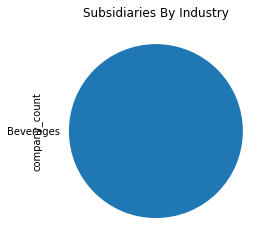

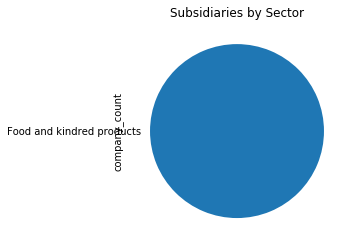

Subsidiaries locations: {'US', 'HN', 'SV', 'SG', 'LB', 'FR', 'JP', 'CH', 'RS', 'ZA', 'NI', 'VE', 'HU', 'AZ', 'KY', 'UY', 'SZ', 'KR', 'BY', 'LU', 'ES', 'SK', 'BA', 'AU', 'PY', 'VG', 'PL', 'CR', 'GI', 'BD', 'PH', 'KG', 'JO', 'IL', 'LT', 'BS', 'AM', 'CY', 'SE', 'BO', 'KZ', 'CZ', 'FI', 'BB', 'EG', 'GB', 'AN', 'EC', 'DO', 'CO', 'MX', 'TW', 'RO', 'MY', 'CN', 'LV', 'LI', 'PE', 'PT', 'AE', 'BG', 'HK', 'BH', 'AT', 'CA', 'KH', 'IT', 'CL', 'NZ', 'TH', 'PK', 'MA', 'VI', 'VN', 'UA', 'NO', 'NL', 'BE', 'IN', 'DE', 'TT', 'HR', 'UZ', 'MU', 'BM', 'GT', 'IE', 'RU', 'TR', 'MD', 'PA', 'BR', 'NG', 'EE', 'ID', 'SA', 'LK', 'AR', 'DK', 'GR'}
==================== SUBSIDIARIES BY INDUSTRY ============================= 
Beverages
	 	 	 PEPSICO INC PURCHASE, NY 


In [79]:
generate_company_report(1419)

In [ ]:


-----
    #RACHEL"S NOTE: This function should end here and return a tuple with the dataframe and a list
    #The code below should be in the top level of the notebook 
    x = 0
    while x < 3:
        choice = None
        if df.size == 0:
            print("I'm sorry, I wasn't able to find a company with those attributes. Would you like to do next:")
            print("1) Search for another company?")
            print("2) Go Back")
            choice = int(input("> "))
        elif df.size != 1:
            print('which company would you like to select (cw_id):')   
            cw = int(input('>'))
            company = df.loc[df['cw_id'] == cw, ['company_name', 'child_cw_id_list'] ]
        else:
            company = df.iloc[0]
            print(company)

        if choice != None:
            print('What would you like to do now:')
            print('1) Search for another Company')
            print('2) Go Back')
            print('3) Get Company Report')
            choice = int(input("> "))
        else:
            if choice == 1:
                company_suggestions()
            elif choice == 2:
                test = ''
                #go back to previous page
            elif choice == 3:
                display_breakdown(company, cw)
            else:
                print('Sorry I didnt get that, please select another choice')
        x+=1
    print('Sorry you have failed too many times. Please try again')
    sys.exit()
    
    return None#ranked list of company suggestions

In [27]:
#Dummy method displays single row, list of children ids 
#Returns a Dataframe 
def display_company_report(cw_id, df):
    """
    given a clean company name, show a display report of the company 
    
    SIC 
    LOC
    F/D % percent of companies that are abroad vs. domestic
    
    
    Requirements: Corpwatch Company data, company relationship data

    """
    print("row")
    row = df.loc[cw_id]
    
    clean_company_name = row[COMPANY_NAME]
    #display_breakdown(clean_company_name)
    #display_hierarchy(clean_company_name)
    
    #display something
    #return the report

    print("Company report for " + str(cw_id) + " " + str(clean_company_name))
    children = row['child_cw_id_list']
    ls = [x for x in children]
    print("Child list " + str(ls[0:10]))
    df[(df.index).isin(ls)]
    return 

In [151]:
def display_hierarchy(clean_company_name):
    '''
    uses logic to determine if it should display (e.g. does it have at least a parent or a child)
    
    if so, show table of parent (if applicable)
    show table of children (if applicable)
    '''
    return []

In [152]:
if result == 'sector':
    #show sector group
    
    sector_company_list = search_by_sector(sector_name): #returns all companies in sector
    company = display_dropdown(sector_company_list) #displays companies with subsidiaries 
    display_company_report(company) #navigates to company report if selected
    #show sector name
    #show industry name

    

SyntaxError: invalid syntax (<ipython-input-152-28a92fa8f6e5>, line 4)

# ACTUAL PAGE


In [28]:

# Rachel has re written this slightly 
import re
import sys
from IPython.display import display, HTML
def display_company_suggestions(df, company, sector):
    print("Displaying the sugessionts ")
   # print(df.columns)
    '''
    if name isn't clean, then search name+wildcard to return list of companies, ranked by number of children.
    can remove
    '''
    
    '''
    first test if name entered finds something in the database
    '''
    df['weighted_result'] = 'default'

    df = df[ df['company_name'].str.match(company) ]

    df['weighted_result'] = df[['num_children','sector_name','company_type']].apply(lambda x: weighted_result(x,sector), axis=1)
    df = df.sort_values(by=['weighted_result'], ascending = False)
    return df


In [30]:
#add a company type column to the dataset
excluded_count = {}
def get_comp_type(row):
    #row['company_name'] = x['company_name'].strip()
    #name = ['company_name'].split()
    name = str(row).split()
    if len(name[-1]) > 4: #takes care of both 1 word company and edge cases where the last section isn't LLC, CORP, INC, etc.)
        if name[-1] not in excluded_count:
            excluded_count[name[-1]] = 1
        else: 
            excluded_count[name[-1]] += 1
        return None 
    else:
        return name[-1].upper()
    
    #return name[-1]
#company_joined2['company_type'] = 'default'
company_data['company_type'] = company_data['company_name'].apply(lambda x: get_comp_type(x))
#for key in excluded_count: #gives us a headcount of what was taken out 
    #print (key, excluded_count[key])

In [31]:
company_data.head()

,Unnamed: 0,row_id,most_recent,year,cik,irs_number,best_location_id,sic_code,industry_name,sic_sector,...,no_sic,child_cw_id_list,parent_cw_id,clean_company,child_cw_id,parent_cw_id_list,city,state,country_code,company_type
cw_id,,,,,,,,,,,,,,,,,,,,,
37,0,18,1,2019,3153,630004250.0,74,4911.0,Electric services,4900.0,...,0,"[1665, 993179, 101861, 1018259, 781, 101870, 1...","[12009.0, 22569.0, 781.0, 1197.0, 1665.0]",['Alabama Power Co'],37.0,"[12009, 22569, 781, 1197, 1665]",BIRMINGHAM,AL,US,CO
45,1,24,1,2019,3499,510100517.0,88,6798.0,Real estate investment trusts,6700.0,...,0,"[1038175, 1038176, 1038177, 1038178, 1038179, ...","[14480.0, 9019.0]",['Alexanders Inc'],45.0,"[14480, 9019]",PARAMUS,NJ,US,INC
69,2,39,1,2019,4515,131502798.0,137,4512.0,"Air transportation, scheduled",4500.0,...,0,"[964843, 964842, 411832, 411833, 416126, 41613...",[105.0],['American Airlines Inc'],69.0,[105],FT WORTH,TX,US,INC
120,3,65,1,2019,6879,540124790.0,246,4911.0,Electric services,4900.0,...,0,"[993634, 834826, 696650, 992937, 136825, 95658...","[956587.0, 1029138.0, 75.0, 927.0, 1345.0, 149...",['Appalachian Power Co'],120.0,"[956587, 1029138, 75, 927, 1345, 1492, 1674]",COLUMBUS,OH,US,CO
130,4,79,1,2019,7323,831918668.0,273,4911.0,Electric services,4900.0,...,0,"[899487, 1001712, 1180]",[590084.0],['Entergy Arkansas LLC'],130.0,[590084],LITTLE ROCK,AR,US,LLC


In [32]:
#Add sector logic here
print('Please input a company you would like to search for')
print('Tips for searching:')
print('-You can enter a partial number')
company = input('> ').upper()
sector = input('What sector are you looking for: ')
print("Searching for relevant companies with names matching " + company + " in sector " + sector)
MAX_REPEATS = 10
repeats = 0
company_id = None
choice = None
df = display_company_suggestions(company_data, company, sector)
while(repeats < MAX_REPEATS):
    print("enter the loop")
    print("data frame size " + str(df.size))
    repeats = repeats = repeats + 1
    if df.size == 0:
        print("I'm sorry, I wasn't able to find a company with those attributes. Would you like to do next:")
        print("1) Search for another company?")
        choice = int(input("> "))
    elif df.size == 1:
        company_id = df[cw_id][0]
        # This continued logic should be removed 
#         print('What would you like to do now:')
#         print('1) Search for another Company')
#         print('2) Go Back')
#         print('3) Get Company Report')
    elif df.size > 1:
        display(df)
        print(" ======================================")
        print('which company would you like to select (cw_id):')
        d = df[COMPANY_NAME].to_dict()
        company_names = dict(map(reversed, d.items()))
        cw_id = display_drop_down_beta(company_names)
        print("Got id  " + str(cw_id))
        print("after searching id  " + str(cw_id))
        df = display_company_report(cw_id, df)
    if company_id is not None:
        if choice == 1:
            df = display_company_suggestions(company_data, company, sector)
        elif choice == 2:
            print('Please input a company you would like to search for')
            print('Tips for searching:')
            print('-You can enter a partial number')
            company = input('> ').upper()
            sector = input('What sector are you looking for: ')
            
        elif choice == 3:
            display_breakdown(company_id)
        else:
            print('Sorry I didnt get that, please select another choice')


Please input a company you would like to search for
Tips for searching:
-You can enter a partial number
> berkshire
What sector are you looking for: insurance
Searching for relevant companies with names matching BERKSHIRE in sector insurance
Displaying the sugessionts 
enter the loop
data frame size 120


/Users/maxingraham-rakatansky/Mims/mims/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Unnamed: 0,row_id,most_recent,year,cik,irs_number,best_location_id,sic_code,industry_name,sic_sector,...,child_cw_id_list,parent_cw_id,clean_company,child_cw_id,parent_cw_id_list,city,state,country_code,company_type,weighted_result
cw_id,,,,,,,,,,,,,,,,,,,,,
16297,585538,2731460,1,2019,1067983,470813844.0,30634,6331.0,"Fire, marine & casualty insurance",6300.0,...,"[90080, 90081, 993209, 835450, 835451, 835452,...",NaN,NaN,NaN,[],OMAHA,NE,US,INC,1.0
4247,573631,2591966,1,2013,759718,942563513.0,8300,6022.0,State commercial banks,6000.0,...,[],NaN,NaN,NaN,[],NaN,NaN,NaN,INC,0.7
19267,588466,2761599,1,2019,1108134,43510455.0,36188,6036.0,"Savings institutions, not federally chartered",6000.0,...,"[995780, 698867, 739249, 713637, 115833, 70782...",NaN,NaN,NaN,[],BOSTON,MA,US,INC,0.7
17250,323,4668,1,2019,1081316,942213782.0,32325,4900.0,"Electric, gas & sanitary services",4900.0,...,"[90470, 1381, 18561, 90318, 10641, 790917, 101...",[16297.0],['Berkshire Hathaway Energy Co'],17250.0,[16297],DES MOINES,IA,US,CO,0.5


which company would you like to select (cw_id):
dict_keys(['BERKSHIRE HATHAWAY INC', 'BERKSHIRE BANCORP INC', 'BERKSHIRE HILLS BANCORP INC', 'BERKSHIRE HATHAWAY ENERGY CO'])
Type the item you would like to chooseBERKSHIRE HATHAWAY INC
16297
Got id  16297
after searching id  16297
row
Company report for 16297 BERKSHIRE HATHAWAY INC
Child list [90080, 90081, 993209, 835450, 835451, 835452, 1044999, 90087, 90089, 90090]
enter the loop


AttributeError: 'NoneType' object has no attribute 'size'